<a href="https://colab.research.google.com/github/krishnakantkmr/coursera-deep-learning-specialization/blob/master/oralcancerclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [2]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [9]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/oral",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 131 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['.ipynb_checkpoints', 'cancer', 'non_cancer']

In [12]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())
  

(62, 256, 256, 3)
tf.Tensor(
[[[ 98.78516   64.78516   55.785156]
  [102.44531   69.708984  60.621094]
  [104.04297   64.63672   56.19922 ]
  ...
  [ 52.283203  97.1582    71.7207  ]
  [ 47.802734  95.802734  69.802734]
  [ 50.509766  99.947266  73.228516]]

 [[ 90.08203   51.08203   44.08203 ]
  [107.74805   75.74805   64.74805 ]
  [105.88281   71.88281   61.882812]
  ...
  [ 41.78711   82.16211   58.16211 ]
  [ 56.16992  102.16992   74.16992 ]
  [ 50.88867   94.88867   67.88867 ]]

 [[108.984375  71.984375  63.984375]
  [107.63086   77.63086   67.63086 ]
  [101.08008   72.08008   64.08008 ]
  ...
  [ 41.695312  86.07031   60.882812]
  [ 49.61133   95.61133   67.61133 ]
  [ 45.220703  94.2207    73.2207  ]]

 ...

 [[ 93.04492   70.578125  62.40039 ]
  [108.421875  79.421875  73.421875]
  [104.33984   74.33984   66.33984 ]
  ...
  [123.615234 184.61523  177.61523 ]
  [138.24219  195.24219  186.24219 ]
  [127.927734 187.24219  177.4707  ]]

 [[ 89.96289   58.38672   50.91211 ]
  [100.5

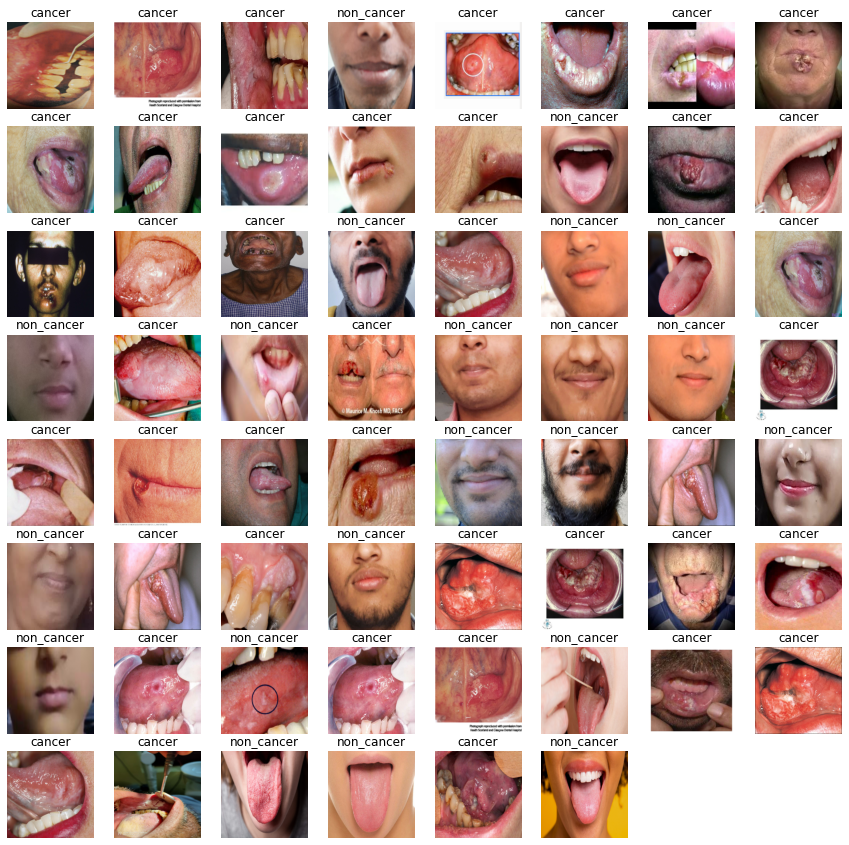

In [13]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/30
2/2 [==============================] - 16s 6s/step - loss: 2.1809 - accuracy: 0.0806
Epoch 2/30
2/2 [==============================] - 13s 6s/step - loss: 1.8636 - accuracy: 0.6694
Epoch 3/30
2/2 [==============================] - 13s 6s/step - loss: 1.0931 - accuracy: 0.6694
Epoch 4/30
2/2 [==============================] - 13s 6s/step - loss: 0.7500 - accuracy: 0.6694
Epoch 5/30
2/2 [==============================] - 13s 6s/step - loss: 0.7149 - accuracy: 0.4435
Epoch 6/30
2/2 [==============================] - 13s 6s/step - loss: 0.6965 - accuracy: 0.6694
Epoch 7/30
2/2 [==============================] - 13s 6s/step - loss: 0.6554 - accuracy: 0.6210
Epoch 8/30
2/2 [==============================] - 13s 6s/step - loss: 0.6351 - accuracy: 0.6774
Epoch 9/30
2/2 [==============================] - 13s 6s/step - loss: 0.6536 - accuracy: 0.6694
Epoch 10/30
2/2 [==============================] - 13s 6s/step - loss: 0.6255 - accuracy: 0.7097
Epoch 11/30
2/2 [======================

In [24]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.4646 - accuracy: 0.8571


[0.46460989117622375, 0.8571428656578064]

In [25]:
acc = history.history['accuracy']
loss = history.history['loss']

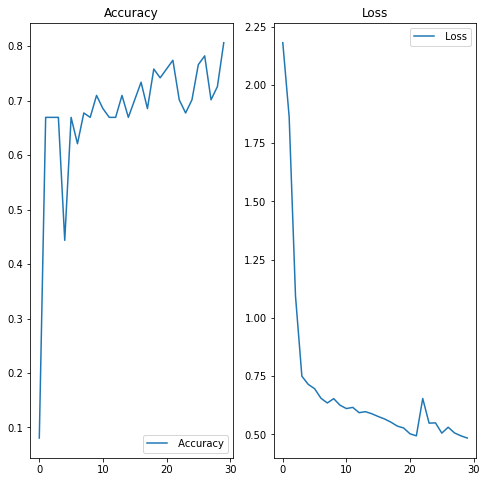

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [28]:
image_path = "/content/squamous-cell-carinoma-of-the-tongue.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

FileNotFoundError: ignored